In [48]:
import csv
import cv2
import numpy as np
import sklearn
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers.core import Dense, Flatten, Activation, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.advanced_activations import ELU
from keras import regularizers
import math
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

In [19]:
samples = []
csv_path = ['data/data/driving_log.csv', 'data/ds1/driving_log.csv', 'data/DSReverse/driving_log.csv']
for j in range(3):
    with open(csv_path[j]) as csvfile:
        #csvlines = csvfile.readlines()  # if we use this method then comment below 3 lines and replace samples by csvlines
        reader = csv.reader(csvfile)
        for line in reader:
             # skip it if ~0 speed - not representative of driving behavior
            if float(line[6]) < 0.1 :
                continue
            if (float(line[3])>0.01 and float(line[3])<0.9) or (float(line[3])>-0.9 and float(line[3])<-0.01):
                samples.append(line)
            else:
                select_prob = np.random.random()
                if select_prob > 0.8:
                    samples.append(line)
                
            #samples.append(line)
        
print(len(samples))
a= np.array(samples)

5698


[-1.         -0.92038732 -0.84077463 -0.76116195 -0.68154926 -0.60193658
 -0.5223239  -0.44271121 -0.36309853 -0.28348584 -0.20387316 -0.12426048
 -0.04464779  0.03496489  0.11457758  0.19419026  0.27380294  0.35341563
  0.43302831  0.512641    0.59225368  0.67186636  0.75147905  0.83109173
  0.91070442  0.9903171 ] [  63    3    9   15   10   22   68   83  160  252  427  706 2066  642  671
  170  126   86   39    6    8    2    0    1   63    1]


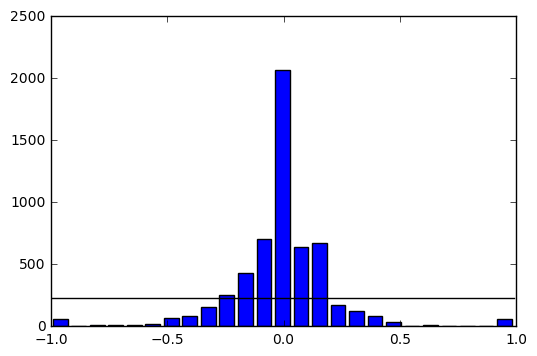

In [20]:
# print a histogram to see which steering angle ranges are most overrepresented
a_angles = a[:,3].astype(np.float)
num_bins = 25
avg_samples_per_bin = len(a)/num_bins
hist, bins = np.histogram(a_angles, num_bins)
width = 0.8 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(a_angles), np.max(a_angles)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')

hist = np.concatenate((hist, [1]))  # because no of bins are 26 (0 to 25), but no of hist were 25.(see print(bins, hist) below)
print(bins, hist)

In [21]:
#http://stackoverflow.com/questions/14947909/python-checking-to-which-bin-a-value-belongs/14947961
# Which angle belongs to which bin......
my_list = a_angles  # list of angles
digitized = np.digitize(my_list,bins)  # for list of angles
x = 51
print(my_list[x], digitized[x], bins[digitized[x]], bins[12], hist[12], avg_samples_per_bin * 0.5)

-0.05975719 12 -0.044647792 -0.044647792 2066 113.96


In [22]:
digitized = np.digitize(1.0,bins)-1   # for single angle
digitized
print(digitized, bins[digitized], hist[digitized])

25 0.9903171 1


In [36]:
car_images = []
steering_angles = []

threshold = avg_samples_per_bin

def Augmentation(row):
    
    steering_center = float(row[3])
    
    # create adjusted steering measurements for the side camera images
    correction = 0.12     # this is a parameter to tune
    steering_left = steering_center + correction
    steering_right = steering_center - correction
    
    # read in images from center, left and right cameras
    path = 'data/data/' # fill in the path to your training IMG directory
    
    img_center =  np.asarray(Image.open(path+row[0]))
    img_center_flipped = np.fliplr(img_center)
    car_images.append(img_center)
    car_images.append(img_center_flipped)
    steering_angles.append(steering_center)
    steering_angles.append(-steering_center)
    
    img_left =  np.asarray(Image.open(path+row[1]))
    img_left_flipped = np.fliplr(img_left)
    car_images.append(img_left)
    car_images.append(img_left_flipped)
    steering_angles.append(steering_left)
    steering_angles.append(-steering_left)
    
    img_right =  np.asarray(Image.open(path + row[2]))
    img_right_flipped = np.fliplr(img_right)
    car_images.append(img_right)
    car_images.append(img_right_flipped)
    steering_angles.append(steering_right)
    steering_angles.append(-steering_right)
        
        
    #print(car_images[1].shape,steering_angles)

In [37]:
global car_images
global steering_angles

for row in samples:
    Augmentation(row)
    #threshold = avg_samples_per_bin * 0.5
    #if len(steering_angles)%5000==0:
        #avg_samples_per_bin = len(steering_angles)/num_bins

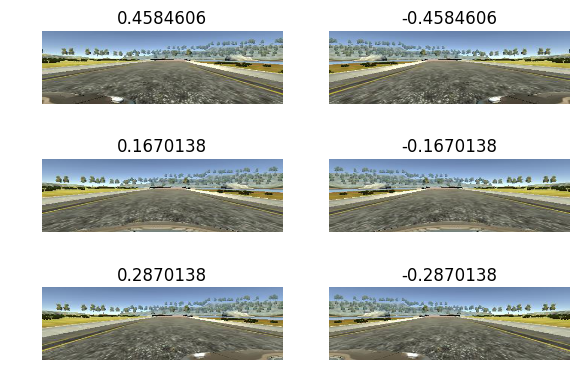

In [38]:
#Sample example

#Augmentation(a[300])
for i in range(100,106):
    image = car_images[i]
    plt.subplot(3, 2, i-99)  # we want i = 1 to 6 , so 100-99
    plt.tight_layout()
    #print(steering_angles[i])
    plt.imshow(image, aspect='auto')
    plt.title(steering_angles[i])
    plt.axis('off')

[-1.12   -1.0304 -0.9408 -0.8512 -0.7616 -0.672  -0.5824 -0.4928 -0.4032
 -0.3136 -0.224  -0.1344 -0.0448  0.0448  0.1344  0.224   0.3136  0.4032
  0.4928  0.5824  0.672   0.7616  0.8512  0.9408  1.0304  1.12  ] [ 126  132  141   33   51  116  230  489  792 1831 2944 6774 6870 6774 2944
 1831  792  489  230  116   51   33  141  132  126    1]


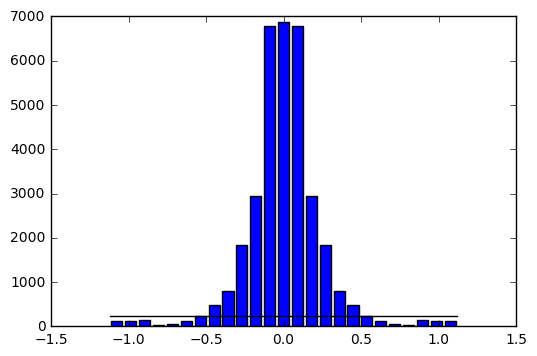

In [39]:
# print a histogram to see which steering angle ranges are most overrepresented
b_angles = steering_angles
num_bins = 25
avg_samples_per_bin = len(a)/num_bins
hist, bins = np.histogram(b_angles, num_bins)
width = 0.8 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(b_angles), np.max(b_angles)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')

hist = np.concatenate((hist, [1]))  # because no of bins are 26 (0 to 25), but no of hist were 25.(see print(bins, hist) below)
print(bins, hist)

In [55]:
car_images2 = []
steering_angles2 = []

def SubSample(car_images, steering_angles):
    # determine keep probability for each bin: if below avg_samples_per_bin, keep all; otherwise keep prob is proportional
    # to number of samples above the average, so as to bring the number of samples for that bin down to the average
    keep_probs2 = []
    target = 2000
    for i in range(num_bins):
        print(bins[i])
        if hist[i] < target:
            keep_probs2.append(1.)
        else:
            keep_probs2.append(1./(hist[i]/target))
    for i in range(len(steering_angles)):
        for j in range(num_bins):
            if steering_angles[i] > bins[j] and steering_angles[i] <= bins[j+1]:
                # delete from X and y with probability 1 - keep_probs[j]
                if np.random.rand() < keep_probs2[j] and steering_angles[i]>=-0.99 and steering_angles[i]<=0.99:
                    car_images2.append(car_images[i])
                    steering_angles2.append(steering_angles[i])

-0.9699279
-0.892333668
-0.814739436
-0.737145204
-0.659550972
-0.58195674
-0.504362508
-0.426768276
-0.349174044
-0.271579812
-0.19398558
-0.116391348
-0.038797116
0.038797116
0.116391348
0.19398558
0.271579812
0.349174044
0.426768276
0.504362508
0.58195674
0.659550972
0.737145204
0.814739436
0.892333668
[-0.9679578  -0.89044237 -0.81292694 -0.73541152 -0.65789609 -0.58038066
 -0.50286523 -0.4253498  -0.34783438 -0.27031895 -0.19280352 -0.11528809
 -0.03777266  0.03974276  0.11725819  0.19477362  0.27228905  0.34980448
  0.4273199   0.50483533  0.58235076  0.65986619  0.73738162  0.81489704
  0.89241247  0.9699279 ] [  10  149   32   44  112  182  346  661 1256 1667 2037 2045 1943 2026 1995
 1717 1236  640  339  181  110   44   33  149   10    1]


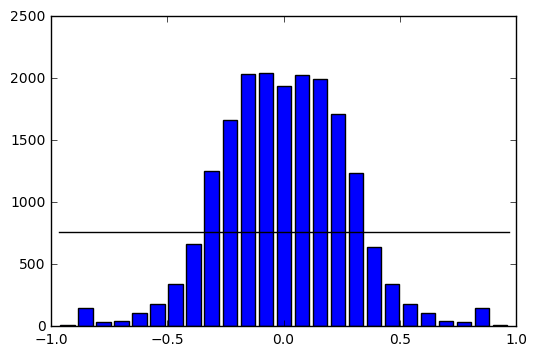

In [56]:
SubSample(car_images, steering_angles)
# print a histogram to see which steering angle ranges are most overrepresented
b_angles2 = steering_angles2
num_bins = 25
avg_samples_per_bin = len(steering_angles2)/num_bins
hist, bins = np.histogram(b_angles2, num_bins)
width = 0.8 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(b_angles2), np.max(b_angles2)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')

hist = np.concatenate((hist, [1]))  # because no of bins are 26 (0 to 25), but no of hist were 25.(see print(bins, hist) below)
print(bins, hist)

In [57]:
print(len(car_images),len(steering_angles))
print(len(car_images2),len(steering_angles2))
train_images, validation_images, train_angles, Validation_angles  = train_test_split(car_images2,steering_angles2, test_size=0.2)
print (len(car_images2), len(train_images), len(validation_images), len(train_angles), len(Validation_angles))

34188 34188
18964 18964
18964 15171 3793 15171 3793


In [58]:
#car_images = []
#steering_angles = []
i=0

def process_image(image):
    
    shape = image.shape
    # note: numpy arrays are (row, col)!
    image = image[math.floor(shape[0]/4):shape[0]-25, 0:shape[1]]
    image = cv2.resize(image, (64, 64))
    
    #image2 = np.zeros(image.shape, dtype='u1')
    #image2 = brightness_process_image(image, image2)
    
    return image

(64, 64, 3) (64, 10, 3)


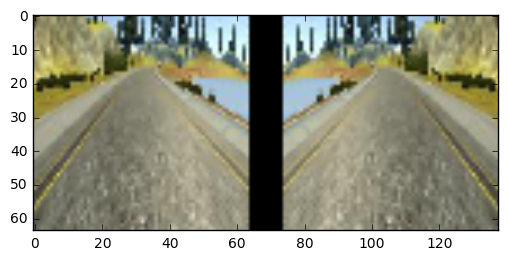

In [59]:
#Sample processing on first image in csv file
path = 'data/data/' # fill in the path to your training IMG directory

divider = np.asarray(np.zeros((64,10,3), dtype='u1'))

#img_center1 = process_image(np.asarray(Image.open(path+csvlines[550][0:38]))) #line[x][0:38], x is row number, [0:38] is characters of first coulmn of that row..
img_center1 = process_image(np.asarray(Image.open(path+samples[250][0])))  #line[x][1], x is row number, [0] is 0th coulmn of that row..
print(img_center1.shape, divider.shape)
img_center1_flipped = np.fliplr(img_center1)
res1 = np.hstack((img_center1, divider, img_center1_flipped))
plt.imshow(res1)


In [60]:
def generator(images_samples, angles_samples, batch_size=32):
    num_samples = int(len(images_samples)*0.3)   # will take 30% of the images
    while 1: # Loop forever so the generator never terminates
        
        shuffle(images_samples,angles_samples)    #images shuffled
        
        for offset in range(0, num_samples, batch_size):    #every epoch we ll have shuffled 30% images
            batch_samples = images_samples[offset:offset+batch_size]
            batch_angles = angles_samples[offset:offset+batch_size]
            
            generator_images = []
            generator_angles = []
            
            for image1 in batch_samples:
                processed_img = process_image(image1)
                generator_images.append(processed_img)
                #generator_angles.append(angle2)
            
            for angle1 in batch_angles:
                generator_angles.append(angle1)
            
            X_train = np.array(generator_images)
            y_train = np.array(batch_angles)
            #print(X_train.shape, y_train.shape)
            yield sklearn.utils.shuffle(X_train, y_train)

In [61]:
# compile and train the model using the generator function
train_generator = generator(train_images, train_angles, batch_size=32)
validation_generator = generator(validation_images, Validation_angles, batch_size=32)

In [62]:
model = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(64,64,3)))
# layer 1 output shape is 32x32x32
model.add(Convolution2D(32, 5, 5, input_shape=(64, 64, 3), subsample=(2, 2), border_mode="same"))
model.add(ELU())
# layer 2 output shape is 15x15x16
model.add(Convolution2D(16, 3, 3, subsample=(1, 1), border_mode="valid"))
model.add(ELU())
model.add(Dropout(.4))
model.add(MaxPooling2D((2, 2), border_mode='valid'))
# layer 3 output shape is 12x12x16
model.add(Convolution2D(16, 3, 3, subsample=(1, 1), border_mode="valid"))
model.add(ELU())
model.add(Dropout(.4))
# Flatten the output
model.add(Flatten())
# layer 4
model.add(Dense(1024))
model.add(Dropout(.3))
model.add(ELU())
# layer 5
model.add(Dense(512))
model.add(ELU())
# Finally a single output, since this is a regression problem
model.add(Dense(1))

Epoch 1/7
27296/27307 [============================>.] - ETA: 0s - loss: 0.0806

/home/carnd/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


27328/27307 [==============================] - 19s - loss: 0.0806 - val_loss: 0.0399
Epoch 2/7
27328/27307 [==============================] - 19s - loss: 0.0374 - val_loss: 0.0388
Epoch 3/7
27328/27307 [==============================] - 19s - loss: 0.0336 - val_loss: 0.0404
Epoch 4/7
27328/27307 [==============================] - 19s - loss: 0.0298 - val_loss: 0.0356
Epoch 5/7
27328/27307 [==============================] - 19s - loss: 0.0266 - val_loss: 0.0379
Epoch 6/7
27328/27307 [==============================] - 19s - loss: 0.0254 - val_loss: 0.0397
Epoch 7/7
27328/27307 [==============================] - 19s - loss: 0.0248 - val_loss: 0.0380
dict_keys(['loss', 'val_loss'])


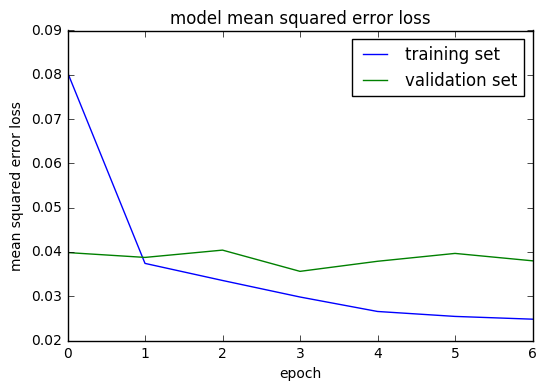

In [63]:
model.compile(loss='mse', optimizer='adam')
#model.fit(X_train, y_train,validation_split=0.2, shuffle=True, nb_epoch=7)
history_object = model.fit_generator(train_generator, samples_per_epoch= \
            len(train_images)*6*0.3, validation_data=validation_generator, \
            nb_val_samples=len(validation_images)*6*0.3, nb_epoch=7, verbose=1)         #https://keras.io/models/sequential/#fit_generator

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

model.save('model_test.h5')

In [ ]:
print(model.summary())